In [ ]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## DoseNet Workshop (ワークショップ)
==========================================================================

In [1]:
# ノートブックをセットアップし、必要なすべてのPythonライブラリをインポートする
# Setup notebook and import all needed python libraries

# Embed plots in the body of the notebook
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

# Standard csv and file io python libraries
import csv
import io
import os
import dateutil

# Library for loading data from a webpage (Python 2 and 3 compatible)
from future.standard_library import install_aliases
install_aliases()
from urllib.request import urlopen, Request

# Main python library for mathematical calculations
import numpy as np
import statistics
from math import log10, floor
import math
from scipy.stats.stats import pearsonr, spearmanr

# Plotting related python libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Python libraries for manipulating dates and times as objects
import time
import datetime as dt
from matplotlib.dates import date2num

In [2]:
# Method for importing DoseNet Data from the website
def importDoseNetCSV(url):
    response = urlopen(url)
    reader = csv.reader(io.TextIOWrapper(response))  
    datetime = []    
    cpm = []
    line = 0
    for row in reader:
        if line != 0:
            datetime.append(dateutil.parser.parse(row[0]))
            cpm.append(float(row[3]))
        line += 1    
        # Python syntax for line = line + 1 (+1 to current value for line)
    return (datetime,cpm)

def importLocalCSV(filepath, filename):
    datetime = []               
    cpm = []
    line = 0                    
        
    file = os.path.join(filepath,filename)
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if line != 0:       
                datetime.append(dateutil.parser.parse(row[0]))     
                cpm.append(float(row[3]))   
            line = line + 1
    return datetime, cpm

In [3]:
# 指定された時間範囲内のデータを選択する方法
# Method for selecting data within the specified time range 
def SelectDataTimeRange(start_time,stop_time,data,times):
    if not start_time.tzinfo:
        start_time = start_time.replace(tzinfo=times[0].tzinfo)
    if not stop_time.tzinfo:
        stop_time = stop_time.replace(tzinfo=times[0].tzinfo)

    dataarray = np.array(data)
    timesarray = np.array(times)

    indices = np.where((timesarray>=start_time)&(timesarray<stop_time))
    subdata  = dataarray[indices]
    subdatatimes = timesarray[indices]
   
    return subdata, subdatatimes

def GetMergedData(start_time,stop_time,data,times,tdelta):
    if not start_time.tzinfo:
        start_time = start_time.replace(tzinfo=times[0].tzinfo)
    if not stop_time.tzinfo:
        stop_time = stop_time.replace(tzinfo=times[0].tzinfo)

    merged_times = []
    merged_data = []
    merged_errs = []

    err_time = tdelta.total_seconds()/60
    date_itr = start_time
    while date_itr < stop_time:
        next_time = date_itr+tdelta
        sub_data, sub_times = SelectDataTimeRange(date_itr,next_time,data,times)
        this_time = date_itr+tdelta/2
        date_itr = next_time
        if len(sub_data)==0:
            merged_point = np.nan
            point_err = np.nan
        else:
            merged_point = sum(sub_data)/len(sub_data)
            point_err = np.sqrt(merged_point*err_time)/err_time
        merged_data.append(merged_point)
        merged_errs.append(point_err)
        #merged_times.append(sub_times[int(len(sub_times)/2)])
        merged_times.append(this_time)
    return merged_data, merged_errs, merged_times

def inTimeRange(time_string,tstart,tstop):
    time = tstart - dt.timedelta(minutes=1)
    if isinstance(time_string, str):
        try:
            time = parse(time_string)
        except:
            #print('{} Not a time!'.format(time_string))
            return False
    elif isinstance(time_string, dt.datetime):
        time = time_string

    # check that tzinfo is set for tz aware comparisons
    if tstart.tzinfo==None:
        tstart = tstart.replace(tzinfo=time.tzinfo)
    if tstop.tzinfo==None:
        tstop = tstop.replace(tzinfo=time.tzinfo)
    #print('Checking {} > {} and < {} = {}'.format(time,tstart,tstop,(time > tstart and time < tstop)))
    return (time > tstart and time < tstop)

In [4]:
# Methods for plotting different types of data
def PlotData(time, data, plot_title, ytitle):    
    fig = plt.figure()
    plt.plot(time, data)
    plt.ylabel(ytitle)                                     # label the y-axis
    plt.title(plot_title)                                  # put a title!
    fig.autofmt_xdate()

def PlotCPM(cpm, time, plot_title):
    PlotData(time, cpm, plot_title, 'Counts per Minute')

def PlotWithErrors(data, data_err, time, plot_title):
    fig = plt.figure()
    plt.plot(time, data)
    plt.errorbar(time, data, yerr=data_err, fmt="none")
    plt.ylabel('Counts Per Minute')                        # label the y-axis
    plt.title(plot_title)                                  # put a title!
    fig.autofmt_xdate()
    

def PlotHistogram(cpm, plot_title):
    plt.hist(cpm,bins=32)
    plt.ylabel('Frequency')
    plt.xlabel('Counts Per Minute')
    plt.title(plot_title)

def PlotComparisonHistograms(plot_title, data1, label1, data2, label2, data3 = [], label3 = ''):
    fig = plt.figure()
    plt.hist(data1,bins=32, alpha = 0.6)
    plt.hist(data2,bins=33, alpha = 0.6)
    if len(data3):
        plt.hist(data3, bins=34, alpha = 0.6)
    plt.ylabel('Frequency')
    plt.xlabel('Counts Per Minute')
    plt.title(plot_title)
    legend_labels = [label1, label2]
    if len(data3):
        legend_labels.append(label3)
    plt.legend(legend_labels, loc='best')

def PlotCorrelation(xdata,x_err,ydata,y_err,xlabel,ylabel):
    plt.plot(xdata,ydata, 'bo')

    #errors based on 1hr count collection time converted to counts-per-second
    # fmt="none" stops the plot from drawing lines connecting each point
    plt.errorbar(xdata, ydata, xerr=x_err, yerr=y_err, fmt="none")

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    title = '{} vs {}'.format(xlabel,ylabel)
    plt.title(title)

    plt.show()

In [5]:
# Method for pulling weather data from specified weather station
def GetWeatherData(ID, date):
    #Scrap weather data of given location and given period of time from websites
    #ID is a string contains weather station ID
    #date is a 1 by 3 string array: Month/Date/Year

    data_temp=[] #Stores raw data from the weather station
    str1 = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID='
    str2 = '&day='
    str3 = '&month='
    str4 = '&year='
    str5 = '&graphspan=day&format=1'
    url = str1+ID+str2+date[1]+str3+date[0]+str4+date[2]+str5
    #print(url)
    response = urlopen(url)
    #cr=csv.reader(response)
    cr=csv.reader(io.TextIOWrapper(response))
    for row in cr:
        if len(row)<= 1: continue
        data_temp.append(row)
    
    #Stores data with correct data type (datetime/string/double)
    data = [[0 for i in range(len(data_temp[1][:])-3)] for j in range(len(data_temp))]
    
    for i in range(len(data_temp)):
        if i == 0:
            data[0][:]=data_temp[0][0:len(data_temp[i][:])-2]
        elif i > 0:
            data[i][0]=dt.datetime.strptime(data_temp[i][0], '%Y-%m-%d %H:%M:%S')
            data[i][1:data_temp[0][:].index('WindDirection')]=tuple(float(list_item) for list_item in data_temp[i][1:data_temp[0][:].index('WindDirection')])
            data[i][data_temp[0][:].index('WindDirection')] = data_temp[i][data_temp[0][:].index('WindDirection')]
            data[i][data_temp[0][:].index('WindDirection')+1:data_temp[0][:].index('Conditions')] = tuple(float(list_item) for list_item in data_temp[i][data_temp[0][:].index('WindDirection')+1:data_temp[0][:].index('Conditions')])
            data[i][data_temp[0][:].index('Conditions'):data_temp[0][:].index('Clouds')+1] = data_temp[i][data_temp[0][:].index('Conditions'):data_temp[0][:].index('Clouds')+1]
            data[i][data_temp[0][:].index('Clouds')+1:len(data_temp[0][:])-2] = tuple(float('0'+list_item) for list_item in data_temp[i][data_temp[0][:].index('Clouds')+1:len(data_temp[i][:])-3])
    
    return data

def GetWeatherStationData(data):
    #Import data from weather station
    date = []
    temperature = []
    pressure = []
    windSpeed = []
    humidity = []
    hourPrecep = []
    solarRadiation = []
    WindDirection = []
    line = 0
    for row in data:
        #skip first row (row that specifies fields)
        if line != 0:
            date.append(row[0])
            temperature.append(row[1])
            pressure.append(row[3])
            windSpeed.append(row[6])
            humidity.append(row[8])
            hourPrecep.append(row[9])
            solarRadiation.append(row[13])
            WindDirection.append(row[4])
        line += 1
    return date, temperature, pressure, humidity, hourPrecep

def GetWeatherDataRange(location,nhours,tstart,tstop,data_type):
    date_itr = tstart
    times = []
    wdata = []
    werrs = []
    data_index = -1
    if data_type == 'Temp':
        data_index = 1
    elif data_type == 'Humid':
        data_index = 8
    elif data_type == 'Press':
        data_index = 3
    elif data_type == 'Rain':
        data_index = 9
    elif data_type == 'Rad':
        data_index = 13

    while date_itr < tstop:
        date = [str(date_itr.month),str(date_itr.day),str(date_itr.year)]
        data = GetWeatherData(location, date)
        time_itr = date_itr
        date_itr = date_itr+dt.timedelta(days=1)
        if not data:
            print('No weather data for {}'.format(date_itr))
        while time_itr < date_itr:
            time_next = time_itr+dt.timedelta(hours=nhours)
            integration = [row for row in data if \
                            inTimeRange(row[0],time_itr,time_next)]
            times.append(time_itr+dt.timedelta(hours=nhours)/2)
            this_data = np.nan
            time_itr = time_next
            if len(integration)==0:
                this_data = np.nan
                data_err = np.nan
            else:
                this_data = np.mean(np.asarray([x[data_index] for x in integration]))
                data_err = np.var(np.asarray([x[data_index] for x in integration]))
                data_err = np.sqrt(data_err)
            wdata.append(this_data)
            werrs.append(data_err)

    return times,wdata,werrs


DoseNet data from all stations in our network is available through the website. There are interactive graphs of the data on the weibsite, but to explore further, the raw data can be downloaded and analyzed directly. Here we will look at how the radiation rate is varying at an example station and compare several locations with eachother.

私達のネットワークの全ての計測地でのドーズネットデータはウェブサイトで利用可能です。インタラクティブグラフがウェブサイトにはありますが、更に詳しく掘り下げるために基となるデータをダウンロードして直接分析することも可能です。ではここで、ある計測地での線量率がどのように異なっているかいくつかの場所を比較してみましょう。

In [6]:
url_etch = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch.csv' 
datetime_etch, cpm_etch = importDoseNetCSV(url_etch)
url_jp = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/koriyama_ch.csv' 
datetime_jp, cpm_jp = importDoseNetCSV(url_jp)
url_norra = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/norrareal.csv' 
datetime_norra, cpm_norra = importDoseNetCSV(url_norra)

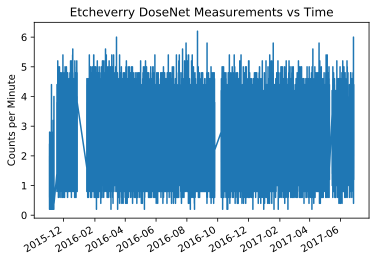

In [7]:
PlotCPM(cpm_etch, datetime_etch, 'Etcheverry DoseNet Measurements vs Time')

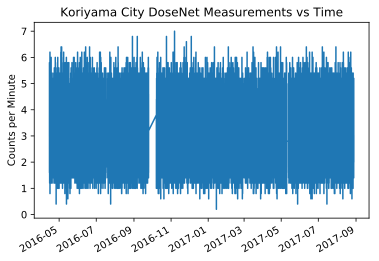

In [8]:
PlotCPM(cpm_jp, datetime_jp, 'Koriyama City DoseNet Measurements vs Time')

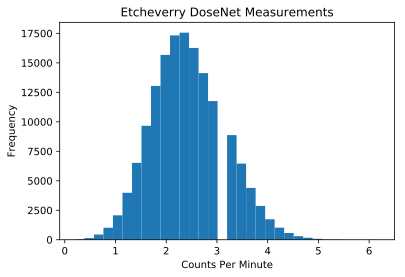

In [9]:
PlotHistogram(cpm_etch,'Etcheverry DoseNet Measurements')

How do you think Berkeley and Koriyama City will compare?

バークレーと郡山市が比較した場合どのようになると思いますか？

Will they have similar dose-rates? 

似たような線量率になると思いますが？

Why might they be different?

それとも何故異なると思いますか？

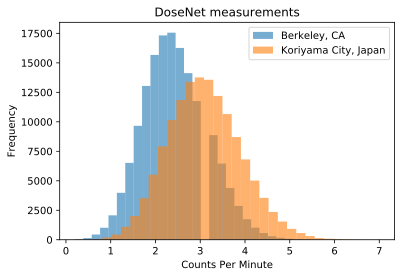

In [10]:
PlotComparisonHistograms('DoseNet measurements',cpm_etch,'Berkeley, CA',cpm_jp,'Koriyama City, Japan')

How will Berkeley and Koriyama City compare with other places around the world?

バークレーと郡山市を世界中の他の場所と比較するとどうなのか？


How do you think they will compare to the rates we see at our location in Stockholm, Sweden?

スウェーデンのストックホルムの線量率とどのように比較すると思いますか？


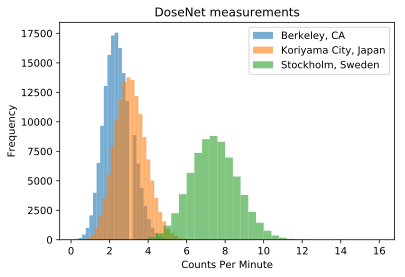

In [11]:
PlotComparisonHistograms('DoseNet measurements',cpm_etch,'Berkeley, CA',cpm_jp,'Koriyama City, Japan',cpm_norra,'Stockholm, Sweden')

Are the rates at these locations statistically different? How could we quantify this comparison?

これらの場所の線量率は統計学的に異なりますか？どのようにこの比較を定量化することができるでしょうか？


### Mean and Variance - 平均と分散

In [ ]:
etch_mean = np.mean(cpm_etch)
etch_sigma = np.sqrt(np.var(cpm_etch))
jp_mean = np.mean(cpm_jp)
jp_sigma = np.sqrt(np.var(cpm_jp))
norra_mean = np.mean(cpm_norra)
norra_sigma = np.sqrt(np.var(cpm_norra))

In [ ]:
print('Average count-rate in Berkeley = {0:.2g} +/- {1:.2g}'.format(etch_mean,etch_sigma))
print('Average count-rate in Koriyama City = {0:.2g} +/- {1:.2g}'.format(jp_mean,jp_sigma))
print('Average count-rate in Stockholm = {0:.2g} +/- {1:.2g}'.format(norra_mean,norra_sigma))

Now look at how the rates at each station vary over the course of a month in more detail:

では、各計測地での1カ月に渡る線量率の変化の詳細を見てみましょう

In [19]:
start_time = dateutil.parser.parse('2017-5-20')
stop_time = dateutil.parser.parse('2017-6-20')
tdelta = dt.timedelta(hours=8)
month_etch, month_etch_times = SelectDataTimeRange(start_time,stop_time,cpm_etch,datetime_etch)
month_etch, etch_errs, month_etch_times = GetMergedData(start_time,stop_time,month_etch,month_etch_times,tdelta)

In [ ]:
PlotWithErrors(month_etch, etch_errs, month_etch_times, 'Etcheverry DoseNet Measurements vs Time')

In [ ]:
month_jp, month_jp_times = SelectDataTimeRange(start_time,stop_time,cpm_jp,datetime_jp)
month_jp, jp_errs, month_jp_times = GetMergedData(start_time,stop_time,month_jp,month_jp_times,tdelta)

month_norra, month_norra_times = SelectDataTimeRange(start_time,stop_time,cpm_norra,datetime_norra)
month_norra, norra_errs, month_norra_times = GetMergedData(start_time,stop_time,month_norra,month_norra_times,tdelta)

In [ ]:
PlotWithErrors(month_jp, jp_errs, month_jp_times, 'Koriyama City DoseNet Measurements vs Time')
PlotWithErrors(month_norra, norra_errs, month_norra_times, 'Koriyama City DoseNet Measurements vs Time')

Are there statistically significant variations over time? Are the variations correlated from one station to another? 

統計的に重要な変化が時間とともにありますか？変化は他の計測地と相互関係がありますか？

Let's check that:

確認してみましょう：

In [ ]:
PlotCorrelation(month_etch,etch_errs,month_jp,jp_errs,'Berkeley CPM','Koriyama CPM')

### Looking beyond basic measurements of rates - 線量率の基本測定値とその先に目を向けてみましょう

We monitor the rates for several naturally occurring and man-made sources of radiation present in the atmosphere using an air filtration system coupled with a high-purity Germanium detector. 

空気中に存在する幾つかの自然放射線と人工放射線を高純度ゲルマニウム検出器を使用して計測します。

The rates for the most commonly occurring natural sources, uranium (Bi-214) and potassium (K-40) are plotted below together with man-made sources (Cs-134, Cs-137).

最も一般的な放射線源であるウラン(Bi-214)とカリウム(K-40)は人工的な線源と共に下記に表示しています。


In [12]:
# import data from air monitor for all isotopes
date = []
Bi214 = []
Bi_err = []
K40 = []
K_err = []
Cs134 = []
Cs4_err = []
Cs137 = []
Cs7_err = []
line = 0
url = 'https://radwatch.berkeley.edu/sites/default/files/pictures/rooftop_tmp/weather.csv'
response = urlopen(url)

reader = csv.reader(io.TextIOWrapper(response))
for row in reader:
    # skip meta-data
    if line == 0:
        print('')
        print("Time, Bi-214, K-40, Cs-134, Cs-137")
    else:
        date.append(dt.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S'))
        Bi214.append(float(row[1]))
        Bi_err.append(float(row[2]))
        K40.append(float(row[3]))
        K_err.append(float(row[4]))
        Cs134.append(float(row[5]))
        Cs4_err.append(float(row[6]))
        Cs137.append(float(row[7]))
        Cs7_err.append(float(row[8]))
    line += 1

print('collected data between {} and {}'.format(date[0],date[-1]))


Time, Bi-214, K-40, Cs-134, Cs-137
collected data between 2017-06-05 10:00:35 and 2017-06-21 12:42:55


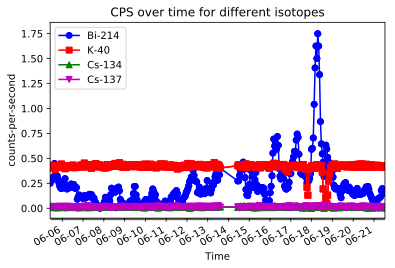

In [14]:
# plot isotope data together
fig, ax = plt.subplots()

ax.plot(date, Bi214, 'bo-', label="Bi-214")
ax.errorbar(date, Bi214, yerr=Bi_err, fmt='bo', ecolor='b')
ax.plot(date, K40, 'rs-', label="K-40")
ax.errorbar(date, K40, yerr=K_err, fmt='rs-', ecolor='r')
ax.plot(date, Cs134, 'g^-', label="Cs-134")
ax.errorbar(date, Cs134, yerr=Cs4_err, fmt='g^-', ecolor='g')
ax.plot(date, Cs137, 'mv-', label="Cs-137")
ax.errorbar(date, Cs137, yerr=Cs7_err, fmt='mv-', ecolor='m')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)
#ax.set_yscale("log", nonposy='clip')

# format the ticks
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_minor_locator(mdates.HourLocator())

# set x-axis scale and display format
ax.set_xlim(date[0], date[-1])
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
# rotates and right aligns the x labels
# moves the bottom of the axes up to make room for them
fig.autofmt_xdate()

plt.ylabel('counts-per-second')
plt.xlabel('Time')
plt.title('CPS over time for different isotopes')

plt.show()

We can also look at whether the rates for various isotopes are correlated, do you expect to see a correlation? Which isotopes might be correlated and why?

また、複数のアイソトープにおける放射線率が相互に関係しているか見てみましょう。相互関係していると思いますか？どことどこのアイソトープが関係しているか、また何故そう思いますか？


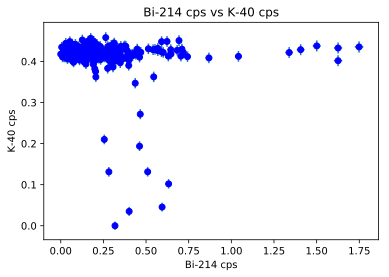

In [15]:
PlotCorrelation(Bi214,Bi_err,K40,K_err,'Bi-214 cps','K-40 cps')

### Relating radiation to the environment - 環境と放射線の関係

Finally, we can look at how radiation rates might be affected by other environmental factors, such as temperature or rainfall.

最後に、放射線率が気温や雨などの環境によってどのように影響を受けるか見てみましょう。


First, we can collect weather data from weather stations in proximity to our detectors in Berkeley.

まず初めに、バークレーの検知器周辺の気象観測所から、気象データを集めることができます。


In [16]:
# Data from weather station
start = ['8','27','2017']
location = 'KCABERKE95'
data = GetWeatherData(location, start)

date, temperature, pressure, humidity, hourPrecep = GetWeatherStationData(data)

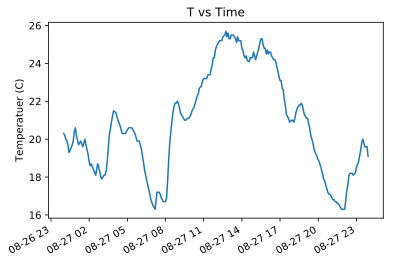

In [17]:
PlotData(date,temperature,'T vs Time','Temperatuer (C)')

We can now look for correlations between the rate of radiation and various environmental factors, such as temperature. 

それでは放射線率と温度などの様々な境要因の相互関係を見てみましょう。


Why might radiation levels vary with temperature, what about rainfall? 

なぜ放射線レベルは気温によって変わる可能性があるのか、降雨はどうなのでしょうか？


What other environmental factors might affect background radiation levels and how could we measure them?

その他どのような環境要因がバックグラウンド放射線レベルに影響するか、またどのようにそれらを計測できるでしょうか？


In [20]:
wtimes, temps, t_errs = GetWeatherDataRange(location,8,start_time,stop_time,'Temp')
wtimes, hums, h_errs = GetWeatherDataRange(location,8,start_time,stop_time,'Humid')
wtimes, rads, s_errs = GetWeatherDataRange(location,8,start_time,stop_time,'Rad')
wtimes, rains, r_errs = GetWeatherDataRange(location,8,start_time,stop_time,'Rain')
wtimes, press, p_errs = GetWeatherDataRange(location,8,start_time,stop_time,'Press')

In [ ]:
PlotCorrelation(temps,t_errs,rads,s_errs,'Local Temp (C)','Solar Radiation')

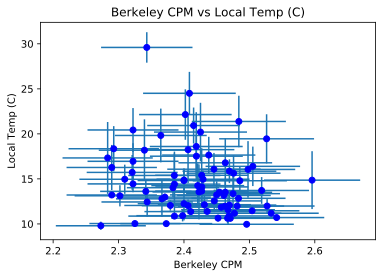

In [21]:
PlotCorrelation(month_etch,etch_errs,temps,t_errs,'Berkeley CPM','Local Temp (C)')

In [ ]:
PlotCorrelation(month_etch,etch_errs,hums,h_errs,'Berkeley CPM','Humidity (%)')

In [ ]:
# A first look at quantifying the correlation
month_etch_clean = [value for value in month_etch if not math.isnan(value)]
hums_clean = [value for value in hums if not math.isnan(value)]
while len(hums_clean) > len(month_etch_clean):
    hums_clean.pop()
while len(hums_clean) < len(month_etch_clean):
    month_etch_clean.pop()

a = pearsonr(month_etch_clean, hums_clean)
#print("Pearson r =", a[0])
#print("P value =", a[1])